This script tries to classify Cancer desease state in binary way. The used dataset is the one below:

https://www.kaggle.com/datasets/erdemtaha/cancer-data

An accuracy of 96.5% is reached using Fully Conected layers

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

In [7]:
cancer_feature = []
labels = []
with open('/kaggle/input/cancer-data/Cancer_Data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        cancer_feature.append(row[2:])
        labels.append(row[1])
labels = [1.0 if item=='M' else 0.0 for item in labels ]

In [8]:
#convert list to array
cancer_feature = np.array(cancer_feature).astype(np.float64)
labels = np.array(labels)

max_values = []
for index in range(30):
    max_values.append(cancer_feature[:, index].max())

#Normalize features
max_values = [1.0 if item <= 1.0 else item for item in max_values]
cancer_feature = np.array([cancer_feature[index]/max_values for index in range(labels.shape[0])])

In [9]:
#split into training and validation sets, 70%, 30%
total_length = labels.shape[0]
split_ratio = 0.85
x_train, y_train = cancer_feature[0:int(split_ratio*total_length)], labels[0:int(split_ratio*total_length)]
x_test, y_test = cancer_feature[int(split_ratio*total_length):], labels[int(split_ratio*total_length):]

In [10]:


x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).unsqueeze(1).float()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).unsqueeze(1).float()
#check


In [11]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([483, 30])
torch.Size([483, 1])
torch.Size([86, 30])
torch.Size([86, 1])


In [13]:
class CancerDataset(Dataset):
    def __init__(self, X, Y):
        self.x_train = X.float()
        self.y_train = Y.float()
    def __len__(self):
        return len(self.y_train)
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index]
    
    
batch_size = 128
train_dataset = CancerDataset(x_train, y_train)
test_dataset = CancerDataset(x_test, y_test)
train_dloader = DataLoader(train_dataset, batch_size=batch_size)
test_dloader = DataLoader(test_dataset, batch_size=batch_size)

for batch, (X,Y) in enumerate(train_dloader):
    print(f"Training data shape: {X.shape}")
    print(f"Training label shape: {Y.shape}")
    break

Training data shape: torch.Size([128, 30])
Training label shape: torch.Size([128, 1])


In [20]:
class MyNN(nn.Module):
    def __init__(self):
        super(MyNN, self).__init__()
        self.lin1 = nn.Linear(30, 10)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(10, 5)
        self.relu2 = nn.ReLU()
        self.lin3 =  nn.Linear(5, 1)
        self.out = nn.Sigmoid()
        
    def forward(self, inputs):
        x1 = self.lin1(inputs)
        x2 = self.relu1(x1)
        x3 = self.lin2(x2)
        x4 = self.relu2(x3)
        x5 = self.lin3(x4)
        return self.out(x5)
    
    
model = MyNN()
print(model)

MyNN(
  (lin1): Linear(in_features=30, out_features=10, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=10, out_features=5, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=5, out_features=1, bias=True)
  (out): Sigmoid()
)


In [21]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [22]:
#We're going to design a single LOOP where network is trained and tested consequently
acc = []
loss_list = []
def train_network(dataloader, nn_model, loss_fn_in, optimizer_in):
    size = len(dataloader.dataset)
    nn_model.train()
    for batch, (X,Y) in enumerate(dataloader):
    #FORWARD
        prediction = nn_model(X)
        loss = loss_fn_in(prediction, Y)
        #BACKWARD PROP
        loss.backward()
        optimizer_in.step()
        optimizer_in.zero_grad()
        if batch%10 == 0:
            loss_list.append(loss)
            current = (batch+1)*len(X)
            print(f"loss: {loss:>7f},   [{current:>5d}/{size:>5d}]")

def test_network(dataloader, nn_model, loss_fn_in):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nn_model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        y_pred = model(x_test)
        y_pred_class = y_pred.round()
        acc.append(y_pred_class.eq(y_test).sum() / float(y_test.shape[0]))
        print(f"Test Accuracy: {acc[-1]:.4f}")


In [23]:
#START TRAINING AND TESTING
epochs = 500
for t in range(epochs):
    print(f"EPOCH: {t+1}\n-------------------------------------")
    train_network(train_dloader, model, loss_fn, optimizer)
    test_network(train_dloader, model, loss_fn)
print("Done!!!")

EPOCH: 1
-------------------------------------
loss: 0.734575,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 2
-------------------------------------
loss: 0.733116,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 3
-------------------------------------
loss: 0.732958,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 4
-------------------------------------
loss: 0.733034,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 5
-------------------------------------
loss: 0.733216,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 6
-------------------------------------
loss: 0.733462,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 7
-------------------------------------
loss: 0.733748,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 8
-------------------------------------
loss: 0.734062,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 9
-------------------------------------
loss: 0.734389,   [  128/  483]
Test Accuracy: 0.7442
EPOCH: 10
-------------------------------------
loss: 0.734720,   [  128/  483]
Test Accura

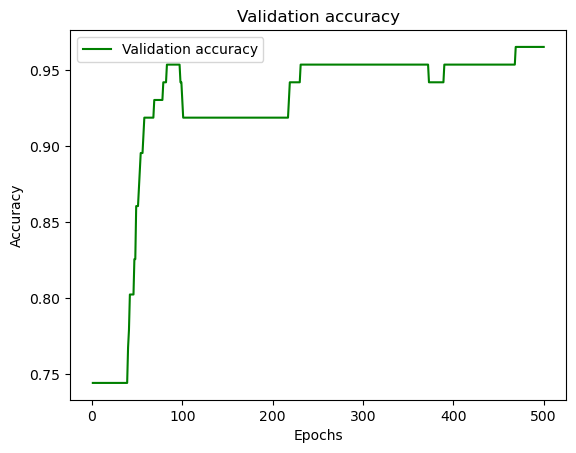

In [24]:
epochs_acc = range(1,len(acc)+1)
plt.plot(epochs_acc, acc, 'g', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

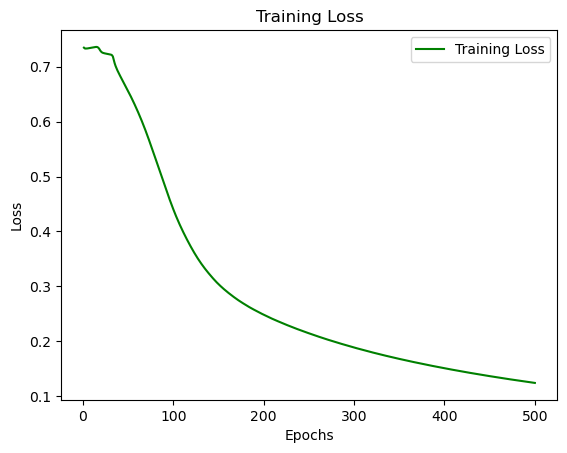

In [25]:
loss_list = [item.detach().numpy() for item in loss_list]
epochs_loss = range(1,len(loss_list)+1)
plt.plot(epochs_loss, loss_list, 'g', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()